# Importer les packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sweetviz as sv
import missingno as msno
import time 
import sys
import os
import csv
from bs4 import BeautifulSoup
import requests
import re

from sklearn.compose import make_column_selector, ColumnTransformer, make_column_transformer
# sklearn.compose: The sklearn.compose module is a submodule of the sklearn library for machine learning in Python. It provides functions for creating complex preprocessing and modeling pipelines.
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PolynomialFeatures,RobustScaler
#sklearn.preprocessing: The sklearn.preprocessing module is a submodule of the sklearn library that provides functions for preprocessing data, such as scaling and normalizing features, imputing missing values, and encoding categorical variables.
from sklearn.linear_model import Ridge,LinearRegression,Lasso, ElasticNet
# sklearn.linear_model: The sklearn.linear_model module is a submodule of the sklearn library that provides functions for fitting linear models for regression and classification.
from sklearn.pipeline import make_pipeline
# sklearn.pipeline: The sklearn.pipeline module is a submodule of the sklearn library that provides functions for creating and working with pipelines of transformers and models.
from sklearn.model_selection import train_test_split,GridSearchCV,learning_curve, RandomizedSearchCV, cross_val_score, KFold
# sklearn.model_selection: The sklearn.model_selection module is a submodule of the sklearn library that provides functions for splitting data into training and test sets, evaluating models using cross-validation, and hyperparameter tuning.
from sklearn.dummy import DummyRegressor
# sklearn.dummy: The sklearn.dummy module is a submodule of the sklearn library that provides simple dummy models for regression and classification.


from sklearn.impute import SimpleImputer
import numpy as np

from sklearn.ensemble import RandomForestClassifier
import pickle


In [6]:
!conda list

# packages in environment at /home/apprenant/miniconda3:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_openmp_mutex             4.5                       1_gnu  
altair                    4.2.0                    pypi_0    pypi
anyio                     3.6.2                    pypi_0    pypi
asgiref                   3.5.2                    pypi_0    pypi
attrs                     22.1.0                   pypi_0    pypi
beautifulsoup4            4.11.1                   pypi_0    pypi
blinker                   1.5                      pypi_0    pypi
branca                    0.6.0                    pypi_0    pypi
brotlipy                  0.7.0           py39h27cfd23_1003  
ca-certificates           2022.3.29            h06a4308_1  
cachetools                5.2.0                    pypi_0    pypi
certifi                   2021.10.8        py39h06a4308_2  
cffi                      1.15.0           p

# Lire les données

In [2]:
try:
    df = pd.read_csv('/home/apprenant/Documents/archive/SBAnational.csv')
except:
    df = pd.read_csv('C:/Users/emada/Downloads/loan_project (1)/SBAnational.csv')

df['ApprovalFY'] = df['ApprovalFY'].replace('A', '', regex=True).astype(int)

/tmp/ipykernel_51435/1292895530.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/home/apprenant/Documents/archive/SBAnational.csv')


# Nettoyage des données

In [3]:
# create a list of all numeric columns
columns_to_transform_to_int = ["DisbursementGross","BalanceGross","ChgOffPrinGr","GrAppv","SBA_Appv"]


for col in columns_to_transform_to_int:
    df[col] = df[col].str.replace("$", "")
    df[col] = df[col].str.replace(",", "")
    df[col] = df[col].astype(float)
    

df['Term'] = df['Term'].astype(int)

df['LowDoc'] = df['LowDoc'].replace({'0': 'N'})
df = df[df['LowDoc'].isin(['N','Y'])]
df['RevLineCr'] = df['RevLineCr'].replace({'0': 'N', 'T':'Y'})
df = df[df['RevLineCr'].isin(['N','Y'])]

dictionnaire =  {"11":"Agriculture, forestry, fishing and hunting","72":"Accommodation and food services","21":"Mining, quarrying, and oil and gas extraction","22":
"Utilities","23":"Construction","31":"Manufacturing","32":"Manufacturing","33":"Manufacturing","42":"Wholesale trade","44":"Retail trade","45":"Retail trade","48":" Transportation and warehousing", "49":"Transportation and warehousing", "51":"Information","52":"Finance and insurance", "53":"Real estate and rental and leasing","54":"Professional, scientific, and technical services","55":"Management of companies and enterprises","56":"Administrative and support and waste management and remediation services","61":"Educational services","62":"Health care and social assistance","71":"Arts, entertainment, and recreation","81":"Other services (except public administration)", "92": "Public administration", "0" : "Other"}

df['NAICS'] = df['NAICS'].astype(str).str[:2]

df["NAICS"] = df["NAICS"].map(dictionnaire)

cols_to_drop = ['LoanNr_ChkDgt', 'Name', 'City', 'Zip', 'Bank', 'BankState', 'ApprovalDate', 'RetainedJob','ChgOffDate', 'DisbursementDate', 'DisbursementGross', 'BalanceGross', 'SBA_Appv', 'ChgOffPrinGr']
df_cleaned = df.copy()
df_cleaned.drop(columns=cols_to_drop, inplace=True)

df_cleaned.dropna(subset=['MIS_Status'], inplace=True)


/tmp/ipykernel_51435/2495417656.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace("$", "")


# Préparation à la modélisation

In [4]:
y = df_cleaned.MIS_Status
X = df_cleaned.drop(columns=['MIS_Status'])

# Pipeline

In [5]:
def make_pipeline_to_ML(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.8, random_state=42)
    numerical_features = make_column_selector(dtype_include=np.number)
    categorical_features = make_column_selector(dtype_exclude= np.number)
    numerical_pipeline = make_pipeline(SimpleImputer(strategy='mean'),StandardScaler(with_mean=False))
    categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(handle_unknown='ignore'))
    preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                                    (categorical_pipeline, categorical_features)
                                    )
    return preprocessor, X_train, X_test, y_train, y_test


# Create the pipeline
preprocessor, X_train, X_test, y_train, y_test = make_pipeline_to_ML(X,y)

# RandomForest
![forest](https://thumbs.gfycat.com/UncomfortableWelllitDrever-size_restricted.gif)

# Rechercher les meilleurs paramètres

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {'randomforestclassifier__n_estimators': np.linspace(100, 250, 10, dtype=int), 'randomforestclassifier__max_depth': np.linspace(1, 10, 5, dtype=int)}

# Create a random forest classifier object
clf = make_pipeline(preprocessor, RandomForestClassifier(class_weight='balanced', n_jobs=-1, verbose=5))

# Create the randomized search object
random_search = RandomizedSearchCV(clf, param_grid, n_iter=10, cv=5, random_state=42, n_jobs=-1, verbose=5)

# Fit the randomized search to the data
random_search.fit(X, y)

# Print the best parameters and the best score
print("Best parameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

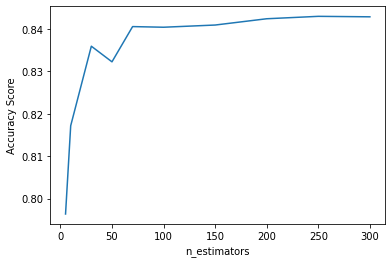

In [1]:
score_list = [0.7963798102637728,
 0.8171832333980801,
 0.8359203896067336,
 0.8322382681642879,
 0.8405427469526785,
 0.8403907327646877,
 0.8409087070348789,
 0.8423894378290122,
0.8429580834952003,
0.8428454803929848
]
n_estimators_list = [5,10,30,50,70,100,150,200, 250,300]

import matplotlib.pyplot as plt

plt.plot(n_estimators_list, score_list)
plt.xlabel("n_estimators")
plt.ylabel("Accuracy Score")
plt.show()

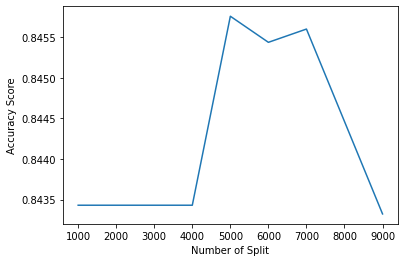

In [2]:
score_list = [0.8434310165245053,
 0.8434310165245053,
 0.8434310165245053,
 0.8457562705852546,
 0.8454353517439406,
 0.845598626242153,
 0.8433240435774005
]
min_samples_split = [1000,3000,4000,5000,6000,7000,9000]

import matplotlib.pyplot as plt

plt.plot(min_samples_split, score_list)
plt.xlabel("Number of Split")
plt.ylabel("Accuracy Score")
plt.show()

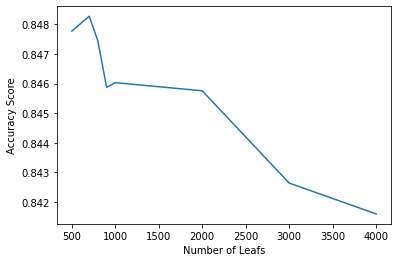

In [3]:
score_list = [0.8477718661149115,
    0.8482729499197703,
    0.8474396869633758,
    0.8458745038425809,
    0.8460321481856825,0.8457562705852546,0.842642794808997,0.8416012161135039
]
min_samples_leaf = [500,700,800,900, 1000,2000,3000,4000]

import matplotlib.pyplot as plt

plt.plot(min_samples_leaf, score_list)
plt.xlabel("Number of Leafs")
plt.ylabel("Accuracy Score")
plt.show()

# Application de nos meilleurs paramètres

In [7]:
# Add the RandomForestClassifier to the pipeline
clf = make_pipeline(preprocessor, RandomForestClassifier(random_state=42, 
                                                        max_depth = 10, 
                                                        n_estimators = 200,
                                                        min_samples_split = 4800,
                                                        min_samples_leaf = 700,
                                                        n_jobs=-1,
                                                        class_weight='balanced'))

# Fit the pipeline on the training data
clf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f314c1c5ff0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f3141720c40>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_leaf=700,
                                        min_samples_split=4800,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))])

In [13]:
from sklearn.metrics import f1_score
# Predict on the test data
y_pred = clf.predict(X_test)

f1_score(y_test, y_pred, average='weighted')

0.8625129142089154

In [14]:
print ("f1_SCORE_MACRO:", {f1_score(y_test, y_pred, average='macro')})

f1_SCORE_MACRO: {0.7852334711728493}


In [16]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      CHGOFF       0.55      0.84      0.67     31281
       P I F       0.96      0.85      0.90    146334

    accuracy                           0.85    177615
   macro avg       0.76      0.85      0.79    177615
weighted avg       0.89      0.85      0.86    177615



In [17]:
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred))

Confusion matrix: 
 [[ 26288   4993]
 [ 21382 124952]]


# Sauvgarder en pkl

In [8]:

# Save the model to a file
with open("RFR_Model.pkl", "wb") as file:
    pickle.dump(clf, file)

# Test FastApi

In [39]:
from fastapi import FastAPI

from typing import Optional
from pydantic import BaseModel
import pickle
import pandas as pd

pickle_in = open('RFR_Model.pkl', 'rb') 
forest_model =pickle.load(pickle_in)

def get_prediction(State, NAICS, ApprovalFY, Term, NoEmp, NewExist, CreateJob, FranchiseCode, UrbanRural, RevLineCr, LowDoc, GrAppv):
    x = [[State, NAICS, ApprovalFY, Term, NoEmp, NewExist, CreateJob, FranchiseCode, UrbanRural, RevLineCr, LowDoc, GrAppv]]
    df = pd.DataFrame(x, columns=['State', 'NAICS', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'GrAppv'])
    y = forest_model.predict(df)[0]
    prob = forest_model.predict_proba(df)[0].tolist()
    return {'prediction': str(y), 'probability': prob}

In [40]:
x_test = [['CA', 'Other', 1997, 240, 6, 1, 0, 1, 0, 'Y', 'N', 540000]]
df_test = pd.DataFrame(x_test, columns=['State', 'NAICS', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'GrAppv'])

# Make prediction using the clf model
y_pred = forest_model.predict(df_test)

# Print the prediction
print(y_pred)


['P I F']


In [ ]:
{
  "State": "CA",
  "NAICS": "Other",
  "ApprovalFY": 1997,
  "Term": 240,
  "NoEmp": 6,
  "NewExist": 1,
  "CreateJob": 0,
  "FranchiseCode": 1,
  "UrbanRural": 0,
  "RevLineCr": "Y",
  "LowDoc": "N",
  "GrAppv": 540000
}
